In [18]:


import os, random, pandas as pd, re, numpy as np, networkx as nx, matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Tuple

DATA_DIR = "/content/drive/MyDrive/"
os.makedirs(DATA_DIR, exist_ok=True)
out_path = os.path.join(DATA_DIR, "energy_corpus.csv")




In [19]:

companies = [
    "Shell", "ExxonMobil", "BP", "Chevron", "TotalEnergies", "Ford", "Toyota",
    "Volkswagen", "BMW", "Mercedes", "General Motors", "Hyundai", "Honda",
    "Nissan", "Stellantis", "Rivian", "Lucid", "BYD", "Tata Motors", "Mahindra"
]
tickers = ["SHEL","XOM","BP","CVX","TTE","F","TM","VWAGY","BMWYY","MBGYY",
           "GM","HYMTF","HMC","NSANY","STLA","RIVN","LCID","BYDDY","TTM","MAHMF"]
analysts = ["Bloomberg", "Fitch", "Morningstar", "Reuters", "Moody", "S&P Global", "Nomura", "Credit Agricole"]
metrics = ["EPS", "P/E Ratio", "Debt Ratio", "Production Index", "Efficiency", "CO2 Emissions", "EV Market Share", "Oil Output"]
regions = ["North America", "Europe", "Asia", "Middle East"]
reports = [f"EnergyReport_{i}" for i in range(1, 61)]
benchmarks = ["Brent Crude", "WTI", "OPEC Basket"]

templates = [
    "{company} ({ticker}) surged as {analyst} upgraded outlook citing improved {metric}.",
    "{report} notes {company} shows resilience against {benchmark} trends.",
    "Analyst {analyst} warned that {company} ({ticker}) faces challenges due to rising {metric}.",
    "According to {report}, {company} {ticker} achieved sustainability targets across {region}.",
    "{company}'s {report} highlighted strong {metric} compared to {benchmark}.",
    "Market analysts at {analyst} forecast {company} ({ticker}) to outperform {benchmark} driven by {metric}.",
    "Recent {report} reveals {company} {ticker} expanding its footprint in {region}.",
    "{report} finds correlation between {company} {ticker} and {benchmark} under {metric} fluctuations.",
    "Financial summary from {analyst} indicates {company} improving {metric} quarter-over-quarter.",
    "{company} ({ticker}) demonstrated leadership in {metric} across {region} per {report}."
]


In [20]:
records = []
for i in range(10000):
    company = random.choice(companies)
    ticker = tickers[companies.index(company)]
    analyst = random.choice(analysts)
    metric = random.choice(metrics)
    region = random.choice(regions)
    report = random.choice(reports)
    benchmark = random.choice(benchmarks)
    text = random.choice(templates).format(
        company=company, ticker=ticker, analyst=analyst,
        metric=metric, report=report, region=region, benchmark=benchmark
    )
    records.append({"doc_id": f"energy{i+1}", "text": text})

df = pd.DataFrame(records)
df.to_csv(out_path, index=False)
print(f"✅ Generated {len(df)} energy-sector rows at:", out_path)
df.head()


✅ Generated 10000 energy-sector rows at: /content/drive/MyDrive/energy_corpus.csv


,doc_id,text
0,energy1,"According to EnergyReport_33, Honda HMC achiev..."
1,energy2,Analyst Credit Agricole warned that Volkswagen...
2,energy3,Financial summary from Morningstar indicates B...
3,energy4,Analyst Fitch warned that BP (BP) faces challe...
4,energy5,Rivian (RIVN) surged as S&P Global upgraded ou...


In [21]:

ENTITY_PATTERNS = {
    "COMPANY": r"[A-Z][a-zA-Z]+\s?(?:Motors|Energy|Mobil|Energies|Honda|Toyota|BMW|Volkswagen|Chevron|Shell)?",
    "STOCK": r"\b[A-Z]{2,6}\b",
    "ANALYST": r"Analyst\s+[A-Z][a-zA-Z]+|[A-Z][a-zA-Z]+\s?(?:Global|Star|Agricole|Reuters|Fitch)",
    "REPORT": r"EnergyReport_[0-9]+",
    "METRIC": r"EPS|P/E Ratio|Debt Ratio|Production Index|Efficiency|CO2 Emissions|EV Market Share|Oil Output",
    "BENCHMARK": r"Brent Crude|WTI|OPEC Basket",
    "REGION": r"North America|Europe|Asia|Middle East"
}

def extract_entities(text: str):
    ents = []
    for typ, pat in ENTITY_PATTERNS.items():
        for m in re.finditer(pat, text):
            ents.append((m.group(0), typ, m.start(), m.end()))
    return ents

records = []
for _, row in df.iterrows():
    ents = extract_entities(row["text"])
    for e, typ, s, t in ents:
        records.append({
            "doc_id": row["doc_id"],
            "entity": e,
            "type": typ,
            "start": s,
            "end": t,
            "context": row["text"][max(0,s-40):min(len(row['text']),t+40)]
        })
ents_df = pd.DataFrame(records)
ents_df.head(10)


,doc_id,entity,type,start,end,context
0,energy1,According,COMPANY,0,10,"According to EnergyReport_33, Honda HMC achiev..."
1,energy1,EnergyReport,COMPANY,13,25,"According to EnergyReport_33, Honda HMC achiev..."
2,energy1,Honda,COMPANY,30,36,"According to EnergyReport_33, Honda HMC achiev..."
3,energy1,HMC,COMPANY,36,40,"According to EnergyReport_33, Honda HMC achiev..."
4,energy1,Asia,COMPANY,79,83,achieved sustainability targets across Asia.
5,energy1,HMC,STOCK,36,39,"According to EnergyReport_33, Honda HMC achiev..."
6,energy1,EnergyReport_33,REPORT,13,28,"According to EnergyReport_33, Honda HMC achiev..."
7,energy1,Asia,REGION,79,83,achieved sustainability targets across Asia.
8,energy2,Analyst,COMPANY,0,8,Analyst Credit Agricole warned that Volkswagen (
9,energy2,Credit,COMPANY,8,15,Analyst Credit Agricole warned that Volkswagen...


In [22]:
def sentence_split(text):
    return re.split(r"(?<=[.!?])\s+", text)

edges = []
for _, r in df.iterrows():
    for sent in sentence_split(r["text"]):
        ents = extract_entities(sent)
        for i in range(len(ents)):
            for j in range(i+1, len(ents)):
                e1, t1, *_ = ents[i]
                e2, t2, *_ = ents[j]
                edges.append({
                    "doc_id": r["doc_id"],
                    "head": e1,
                    "type1": t1,
                    "tail": e2,
                    "type2": t2,
                    "sentence": sent
                })
edges_df = pd.DataFrame(edges)
edges_df.head(10)


,doc_id,head,type1,tail,type2,sentence
0,energy1,According,COMPANY,EnergyReport,COMPANY,"According to EnergyReport_33, Honda HMC achiev..."
1,energy1,According,COMPANY,Honda,COMPANY,"According to EnergyReport_33, Honda HMC achiev..."
2,energy1,According,COMPANY,HMC,COMPANY,"According to EnergyReport_33, Honda HMC achiev..."
3,energy1,According,COMPANY,Asia,COMPANY,"According to EnergyReport_33, Honda HMC achiev..."
4,energy1,According,COMPANY,HMC,STOCK,"According to EnergyReport_33, Honda HMC achiev..."
5,energy1,According,COMPANY,EnergyReport_33,REPORT,"According to EnergyReport_33, Honda HMC achiev..."
6,energy1,According,COMPANY,Asia,REGION,"According to EnergyReport_33, Honda HMC achiev..."
7,energy1,EnergyReport,COMPANY,Honda,COMPANY,"According to EnergyReport_33, Honda HMC achiev..."
8,energy1,EnergyReport,COMPANY,HMC,COMPANY,"According to EnergyReport_33, Honda HMC achiev..."
9,energy1,EnergyReport,COMPANY,Asia,COMPANY,"According to EnergyReport_33, Honda HMC achiev..."


Graph summary:
Nodes: 208 Edges: 12379


/tmp/ipython-input-3780637218.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


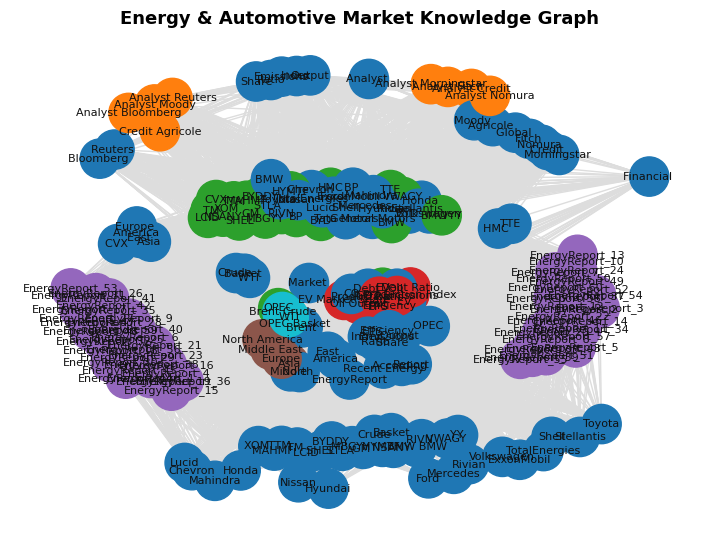

In [23]:
G = nx.Graph()
for _, e in ents_df.iterrows():
    G.add_node(e["entity"], type=e["type"])
for _, ed in edges_df.iterrows():
    G.add_edge(ed["head"], ed["tail"], doc_id=ed["doc_id"], sentence=ed["sentence"])

print("Graph summary:")
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))

# --- Unique color map ---
color_scheme = {
    "COMPANY": "#1f77b4",     # Deep blue
    "STOCK": "#2ca02c",       # Vibrant green
    "ANALYST": "#ff7f0e",     # Orange
    "REPORT": "#9467bd",      # Purple
    "METRIC": "#d62728",      # Red
    "BENCHMARK": "#17becf",   # Cyan
    "REGION": "#8c564b"       # Brown
}

pos = nx.kamada_kawai_layout(G)
node_colors = [color_scheme.get(G.nodes[n].get("type",""), "#aaaaaa") for n in G.nodes()]

plt.figure(figsize=(7,5))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800,
        font_size=8, edge_color="#dddddd", font_color="#111")
plt.title("Energy & Automotive Market Knowledge Graph", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


In [26]:
diversity = {}
for node, data in G.nodes(data=True):
    if data["type"] == "COMPANY":
        linked_types = set(G.nodes[n]["type"] for n in G.neighbors(node))
        diversity[node] = len(linked_types)
top_diverse = sorted(diversity.items(), key=lambda x: x[1], reverse=True)[:5]

# 2️⃣ Identify strongest connected pairs (frequent co-occurrence)
pair_strength = pd.DataFrame(edges_df.groupby(["head", "tail"]).size(), columns=["count"]).reset_index()
top_pairs = pair_strength.sort_values("count", ascending=False).head(5)

# 3️⃣ Print Insights

print("\nTop 5 Companies with Most Diverse Relationships:")
for c, d in top_diverse:
    print(f"🔹 {c}: linked to {d} unique entity types")

print("\nStrongest Company Relationship Pairs:")
for _, row in top_pairs.iterrows():
    print(f"🔸 {row['head']} ↔ {row['tail']}  | Frequency: {row['count']}")



Top 5 Companies with Most Diverse Relationships:
🔹 Honda : linked to 7 unique entity types
🔹 Volkswagen : linked to 7 unique entity types
🔹 BYD : linked to 7 unique entity types
🔹 EPS : linked to 7 unique entity types
🔹 BP : linked to 7 unique entity types

Strongest Company Relationship Pairs:
🔸 EnergyReport ↔ WTI  | Frequency: 2289
🔸 WTI ↔ WTI  | Frequency: 2011
🔸 WTI  ↔ WTI  | Frequency: 1916
🔸 EPS ↔ EPS  | Frequency: 1636
🔸 Brent  ↔ Brent Crude  | Frequency: 1362
